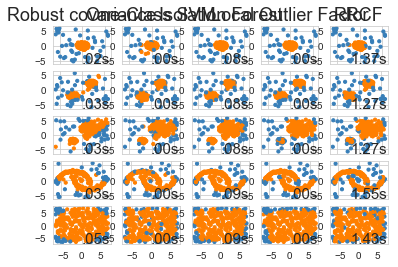

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons, make_blobs
# Set up the algorithms
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import time
import rrcf
sns.set_style("whitegrid")
rng = np.random.RandomState(42)


# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers



# Outlier detectors from sklean plot
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction,
                                      kernel="rbf",
                                      gamma=0.1)),
    ("Isolation Forest", IsolationForest(behaviour='new',
                                         contamination=outliers_fraction,
                                         random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=35,
                                                contamination=outliers_fraction))]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,**blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],**blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],**blobs_params)[0],
    4. * (make_moons(n_samples=n_samples, noise=.05, random_state=0)[0] - np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_samples, 2) - 0.5)]

# Add outliers to the data sets
outliers = []  # record keeping
data = []
for i in datasets:
    out = rng.uniform(low=-6, high=6, size=(n_outliers, 2))
    outliers.append(out)
    data.append(np.concatenate([i, out], axis=0))

# Set forest params
avg_codisp = []
trees  = 50
plot_num = 1

fig = plt.figure(1)

for d in range(0, len(data)):
    forest = []
    tr1 = time.time()
    for _ in range(trees):
        forest.append(rrcf.RCTree(data[d]))

    codisp = np.zeros((data[d].shape[0], trees))
    for tree in range(0, trees):
        for index in range(0, data[d].shape[0]):
            codisp[index, tree] = forest[tree].codisp(index)

    avg_codisp.append(codisp.mean(axis=1))
    tr2 = time.time()


    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(data[d])
        t1 = time.time()
        plt.subplot(5, len(anomaly_algorithms) + 1, plot_num)
        if d == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(data[d])
        else:
            y_pred = algorithm.fit(data[d]).predict(data[d])

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(data[d][:, 0], data[d][:, 1], s=10, color=colors[(y_pred + 1) // 2])
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

    plt.subplot(5, len(anomaly_algorithms) + 1, plot_num)
    avg_cod = avg_codisp[-1]
    mask = np.percentile(avg_cod, 85)
    avg_cod[avg_cod < mask] = 1
    avg_cod[avg_cod > mask] = 0
    c = ['#377eb8' if i == 0 else '#ff7f00' for i in avg_cod]
    plt.scatter(data[d][:,0], data[d][:,1], s=10, c=c)
    if d == 0:
        plt.title("RRCF", size=18)

    plt.text(.99, .01, ('%.2fs' % (tr2 - tr1)).lstrip('0'),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plot_num += 1

plt.show()
